
Note: you may need to restart the kernel to use updated packages.



EnvironmentLocationNotFound: Not a conda environment: C:\Users\Abdul



In [45]:
%%capture
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import numpy as np
import cv2 
%matplotlib inline
import pypher 
import skimage
from skimage.util import random_noise

277 277


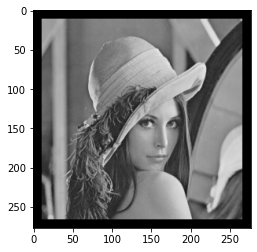

In [5]:
##Reading Data
lena = cv2.imread('lena.png')
x,y,z=lena.shape
print(x,y)
plt.imshow(lena)
plt.show()

In [12]:
##ensure that the motion blur kernel sums up to 1
mb_kernel = cv2.imread('mb-kernel.png')
#motion_blur_kernel = im2double(cv2.imread('mb-kernel.png'));
motion_blur_kernel = cv2.normalize(mb_kernel.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
motion_blur_kernel = motion_blur_kernel/(np.sum(motion_blur_kernel))

In [26]:
## Define Parameters
qx = [1,-1]
qy = np.transpose(qx)
l_start = 0.01
l_end = 2.0
l_step = 0.01
#n_lambdas  = length(l_start:l_step:l_end);
n_lambdas = int(((l_end - l_start)/l_step) + 1 )
print(n_lambdas)

200


In [29]:
##L2 regularized NBD
sigma_n_vals = [8, 8, 8, 5, 10, 15]
sigma_b_vals = [0.5, 1, 1.5, 1, 1, 1]
n_pairs = len(sigma_b_vals)
best_lambdas = np.zeros(np.shape(sigma_b_vals))
rmse_vals = np.zeros([n_pairs, n_lambdas] , dtype= int)
print(n_pairs)

6


In [34]:
#function k_size = kernel_size(sigma)
def kernel_size(sigma):
    k_size = np.ceil(6*sigma)
    if np.mod(k_size, 2) == 0:
        k_size = k_size+1
    return k_size


In [38]:
#function kernel = gaussian_kernel(sigma)
def gaussian_kernel(sigma):
        w = kernel_size(sigma);
        d = np.ceil(w/2);
        if d == 0:
            kernel = ones(w, w);
        else:
            x, y = np.meshgrid(w, w) ## to see
            exponent = -(np.square(x-d) + np.square(y-d))/(2*sigma**2)
            kernel = np.exp(exponent)
            kernel = kernel/sum(kernel)

In [47]:
#function noisy_image = gaussian_noise(image, sigma)
def gaussian_noise(image,sigma):
    #noisy_image = imnoise(image, 'gaussian', 0,  sigma^2);
    noisy_image = random_noise(image,'gaussian', seed=None, clip=True, var = sigma**2)
    return noisy_image

In [48]:
#function degraded_image = degrade(image, blur_param, sigma_n, is_motion_blur)
def degrade(image, blur_param, sigma_n, is_motion_blur):
#        fix the seed
       # rng(1);
#        convert the image to [0,1] range
        #image = im2double(image);
        cv2.normalize(image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
#       convert noise std in the appropriate range
        sigma_n = sigma_n/255;
        if is_motion_blur== False:
            blur_kernel = gaussian_kernel(blur_param);
            blurred_image = convolve2d(image, blur_kernel, 'same')
#               add noise
            degraded_image = gaussian_noise(blurred_image, sigma_n)
        else:
            blurred_image = convolve2d(image, blur_param, 'same')
#               add noise
            degraded_image = gaussian_noise(blurred_image, sigma_n)
        return degraded_image

In [43]:
#function [lambda_best, rmse_vals] = best_lambda(image, blur_param, sigma_n, start_lambda, stop_lambda, step_size, is_motion_blur, reg)
def best_Lambda(image, blur_param, sigma_n, start_lambda, stop_lambda, step_size, is_motion_blur, reg):
        x, y, z = image.shape
        if is_motion_blur == False :
            h = gaussian_kernel(blur_param)
            H = pypher.psf2otf(h, [x, y])
        else :
            H = pypher.psf2otf(blur_param, [x, y])
        qx = [1 -1]
        qy = np.transpose(qx)
        Qx = pypher.psf2otf(qx, [x, y])
        Qy = pypher.psf2otf(qy, [x, y])
        degraded_image = degrade(image, blur_param, sigma_n, is_motion_blur)
        lambda_vals=[]
        t= start_lambda
        for t <= stop_lambda:
            t= t + step_size
            lambda_vals.append(t)
        #lambda_vals = start_lambda:step_size:stop_lambda;
        #n_lambda_vals = length(lambda_vals);
        #rmse_vals = zeros(size(lambda_vals));
        #lambda_best = start_lambda;
        #rmse_best = Inf;    
        n_lambda_vals=len(lambda_vals)
        rmse_vals=np.zeros(np.shape(lambda_vals))
        lambda_best = start_lambda
        rmse_best =  Inf 
        
        
        
            
            
            

In [ ]:

        
        
        if reg == "L1":
                #wait_bar = waitbar(0, ["Finding best lambda with L1 norm regularization..."]);
                for i in range (0,n_lambda_vals-1) 
                        lambda = lambda_vals(i)
                        clean_image = admmfft(degraded_image, h, lambda, 1);
                        rmse = immse(clean_image, degraded_image);
                        rmse_vals(i) = rmse;
                        if rmse < rmse_best
                                rmse_best = rmse;
                                lambda_best = lambda;
                        end
                        waitbar(i/n_lambda_vals);
                end
                close(wait_bar);
        elseif reg == "L2"
                #wait_bar = waitbar(0, "Finding best lambda with L2 norm regularization...");
                for i = 1:n_lambda_vals
                        lambda = lambda_vals(i);
                        G = fft2(degraded_image);
                        freq_trans = conj(H)./(abs(H).^2+lambda*(abs(Qx).^2)+lambda*(abs(Qy).^2));
                        clean_image = abs(ifft2(freq_trans.*G));
                        rmse = immse(clean_image, degraded_image);
                        rmse_vals(i) = rmse;
                        if rmse < rmse_best
                                rmse_best = rmse;
                                lambda_best = lambda;
                        end
                        waitbar(i/n_lambda_vals);
                end
                close(wait_bar);
        end
end

In [ ]:
##Save Results
for i in range (0, n_pairs-1):
        sigma_b = sigma_b_vals(i)
        sigma_n = sigma_n_vals(i)
        best_l, rmse = best_lambda(lena, sigma_b, sigma_n, l_start, l_end, l_step, false, "L2");
        best_lambdas(i) = best_l;
        rmse_vals(i, :) = rmse;
        degraded_image = degrade(lena, sigma_b, sigma_n, false);
        fig0 = figure('visible', 'off');
        imshow(degraded_image)
        name = ['Degraded: \sigma_{b} = ', num2str(sigma_b), ' \sigma_{n} = ', num2str(sigma_n)];
        title(name);
        saveas(fig0, ['L2_degraded_img_sigma_b_', num2str(10*sigma_b), '_sigma_n_', num2str(sigma_n)], 'png');
        fig1 = figure('visible', 'off');
        imshow(deblur_L2_freq(degraded_image, sigma_b, best_l, qx, qy, false))
        name = ['Restored: \sigma_{b} = ', num2str(sigma_b), ' \sigma_{n} = ', num2str(sigma_n), ' \lambda = ', num2str(best_l)];
        title(name);
        saveas(fig1, ['L2_best_img_sigma_b_', num2str(10*sigma_b), '_sigma_n_', num2str(sigma_n)], 'png');
        fig2 = figure('visible', 'off');
        plot(l_start:l_step:l_end, rmse);
        grid on;
        name = ['RMSE: \sigma_{b} = ', num2str(sigma_b), ' \sigma_{n} = ', num2str(sigma_n)];
        title(name);
        xlabel('\lambda');
        ylabel('MSE');
        saveas(fig2, ['L2_rmse_sigma_b_', num2str(10*sigma_b), '_sigma_n_', num2str(sigma_n)], 'png');
end

## Best Looking Results
best_looking_lambdas = [0.15, 0.2, 0.45, 0.09, 0.4, 0.9];
for i = 1:n_pairs
        fig = figure('visible', 'off');
        imshow(deblur_L2_freq(degrade(lena, sigma_b_vals(i), sigma_n_vals(i), false) , sigma_b_vals(i), best_looking_lambdas(i), qx, qy, false));
        name = ['Best Looking: \sigma_{b} = ', num2str(sigma_b_vals(i)), ' \sigma_{n} = ', num2str(sigma_n_vals(i)), ' \lambda = ', num2str(best_looking_lambdas(i))];
        title(name);
        saveas(fig, ['L2_best_looking_img_sigma_b_', num2str(10*sigma_b_vals(i)), '_sigma_n_', num2str(sigma_n_vals(i))], 'png');
end

## L2 vs L1 Regularization
sigma_b = 1.5;
sigma_n_vals = [1, 5, 5];
n_pairs = length(sigma_n_vals);
degraded_1 = degrade(lena, sigma_b, sigma_n_vals(1), false);
degraded_5 = degrade(lena, sigma_b, sigma_n_vals(2), false);
degraded_mb = degrade(lena, motion_blur_kernel, sigma_n_vals(3), true);

fig = figure('visible', 'off');
imshow(degraded_1);
name = ['Degraded: \sigma_{b} = ', num2str(sigma_b), ' \sigma_{n} = ', num2str(sigma_n_vals(1))];
title(name);
saveas(fig, ['L0_degraded_img_sigma_b_', num2str(10*sigma_b), '_sigma_n_', num2str(sigma_n_vals(1))], 'png');

fig = figure('visible', 'off');
imshow(degraded_5);
name = ['Degraded: \sigma_{b} = ', num2str(sigma_b), ' \sigma_{n} = ', num2str(sigma_n_vals(2))];
title(name);
saveas(fig, ['L0_degraded_img_sigma_b_', num2str(10*sigma_b), '_sigma_n_', num2str(sigma_n_vals(2))], 'png');

fig = figure('visible', 'off');
imshow(degraded_mb);
name = ['Degraded: Motion Blur \sigma_{n} = ', num2str(sigma_n_vals(3))];
title(name);
saveas(fig, ['L0_degraded_motion_blur_sigma_n_', num2str(sigma_n_vals(3))], 'png');

## Best Looking Results for L1
fig = figure('visible', 'off');
imshow(deblur_L1(degraded_1, sigma_b, 0.0001, false));
name = ['Best Looking: \sigma_{b} = ', num2str(sigma_b), ' \sigma_{n} = ', num2str(sigma_n_vals(1)), ' \lambda = ', num2str(0.0001)];
title(name);
saveas(fig, ['L1_best_looking_img_sigma_b_', num2str(10*sigma_b), '_sigma_n_', num2str(sigma_n_vals(1))], 'png');

fig = figure('visible', 'off');
imshow(deblur_L1(degraded_5, sigma_b, 0.003, false));
name = ['Best Looking: \sigma_{b} = ', num2str(sigma_b), ' \sigma_{n} = ', num2str(sigma_n_vals(2)), ' \lambda = ', num2str(0.003)];
title(name);
saveas(fig, ['L1_best_looking_img_sigma_b_', num2str(10*sigma_b), '_sigma_n_', num2str(sigma_n_vals(2))], 'png');
        
fig = figure('visible', 'off');
imshow(deblur_L1(degraded_mb, motion_blur_kernel, 0.002, true));
name = ['Best Looking: Motion Blur \sigma_{n} = ', num2str(sigma_n_vals(3)), ' \lambda = ', num2str(0.002)];
title(name);
saveas(fig, ['L1_best_looking_img_motion_blur_sigma_n_', num2str(sigma_n_vals(3))], 'png');
     
## Best Looking Results for L2
fig = figure('visible', 'off');
imshow(deblur_L2_freq(degraded_1, sigma_b, 0.005, qx, qy, false));
name = ['Best Looking: \sigma_{b} = ', num2str(sigma_b), ' \sigma_{n} = ', num2str(sigma_n_vals(1)), ' \lambda = ', num2str(0.005)];
title(name);
saveas(fig, ['L2_best_looking_img_sigma_b_', num2str(10*sigma_b), '_sigma_n_', num2str(sigma_n_vals(1))], 'png');

fig = figure('visible', 'off');
imshow(deblur_L2_freq(degraded_5, sigma_b, 0.2, qx, qy, false));
name = ['Best Looking: \sigma_{b} = ', num2str(sigma_b), ' \sigma_{n} = ', num2str(sigma_n_vals(2)), ' \lambda = ', num2str(0.2)];
title(name);
saveas(fig, ['L2_best_looking_img_sigma_b_', num2str(10*sigma_b), '_sigma_n_', num2str(sigma_n_vals(2))], 'png');
        
fig = figure('visible', 'off');
imshow(deblur_L2_freq(degraded_mb, motion_blur_kernel, 0.07, qx, qy, true));
name = ['Best Looking: Motion Blur \sigma_{n} = ', num2str(sigma_n_vals(3)), ' \lambda = ', num2str(0.07)];
title(name);
saveas(fig, ['L2_best_looking_img_motion_blur_sigma_n_', num2str(sigma_n_vals(3))], 'png');